In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, roc_curve
import random
import joblib
from sklearn.inspection import permutation_importance


## Lecture et prétraitement des données

### Lecture et premières informations

In [50]:
data = pd.read_csv("placementdata.csv")
print(data.info())
data["PlacementStatus"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   StudentID                  10000 non-null  int64  
 1   CGPA                       10000 non-null  float64
 2   Internships                10000 non-null  int64  
 3   Projects                   10000 non-null  int64  
 4   Workshops/Certifications   10000 non-null  int64  
 5   AptitudeTestScore          10000 non-null  int64  
 6   SoftSkillsRating           10000 non-null  float64
 7   ExtracurricularActivities  10000 non-null  object 
 8   PlacementTraining          10000 non-null  object 
 9   SSC_Marks                  10000 non-null  int64  
 10  HSC_Marks                  10000 non-null  int64  
 11  PlacementStatus            10000 non-null  object 
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB
None


PlacementStatus
NotPlaced    5803
Placed       4197
Name: count, dtype: int64

La première chose à remarquer est l'absence de valeurs manquantes, ce qui facilite l'utilisation du dataset.
hormis notre variable d'interêt, nous avons deux variables de type 'object' qu'il faudra donc convertir en 'int64' par une modification. 

On peut percevoir un décalage significatif entre le nombre de Placed et de NotPlaced. On pourrait penser à utiliser des poids de classes rééquilibrés, néanmoins aucune des deux classes ne peut être qualifiée de rare, alors le rééquilibrage n'apporterait aucune réelle amélioration aux modèles.

### Remplacement des variables object

In [51]:
data = data.replace({'Yes': 1, 'No': 0})

## Modèles

#### Séparations des échantillons d'apprentissage et de tests

In [52]:
y = data["PlacementStatus"]
X = data.drop("PlacementStatus", axis=1)

# On retire également la varibale studentID qui n'apporte aucune information utile au modèle
X=X.drop("StudentID", axis=1)

x_train, x_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42)



#### Random Tree

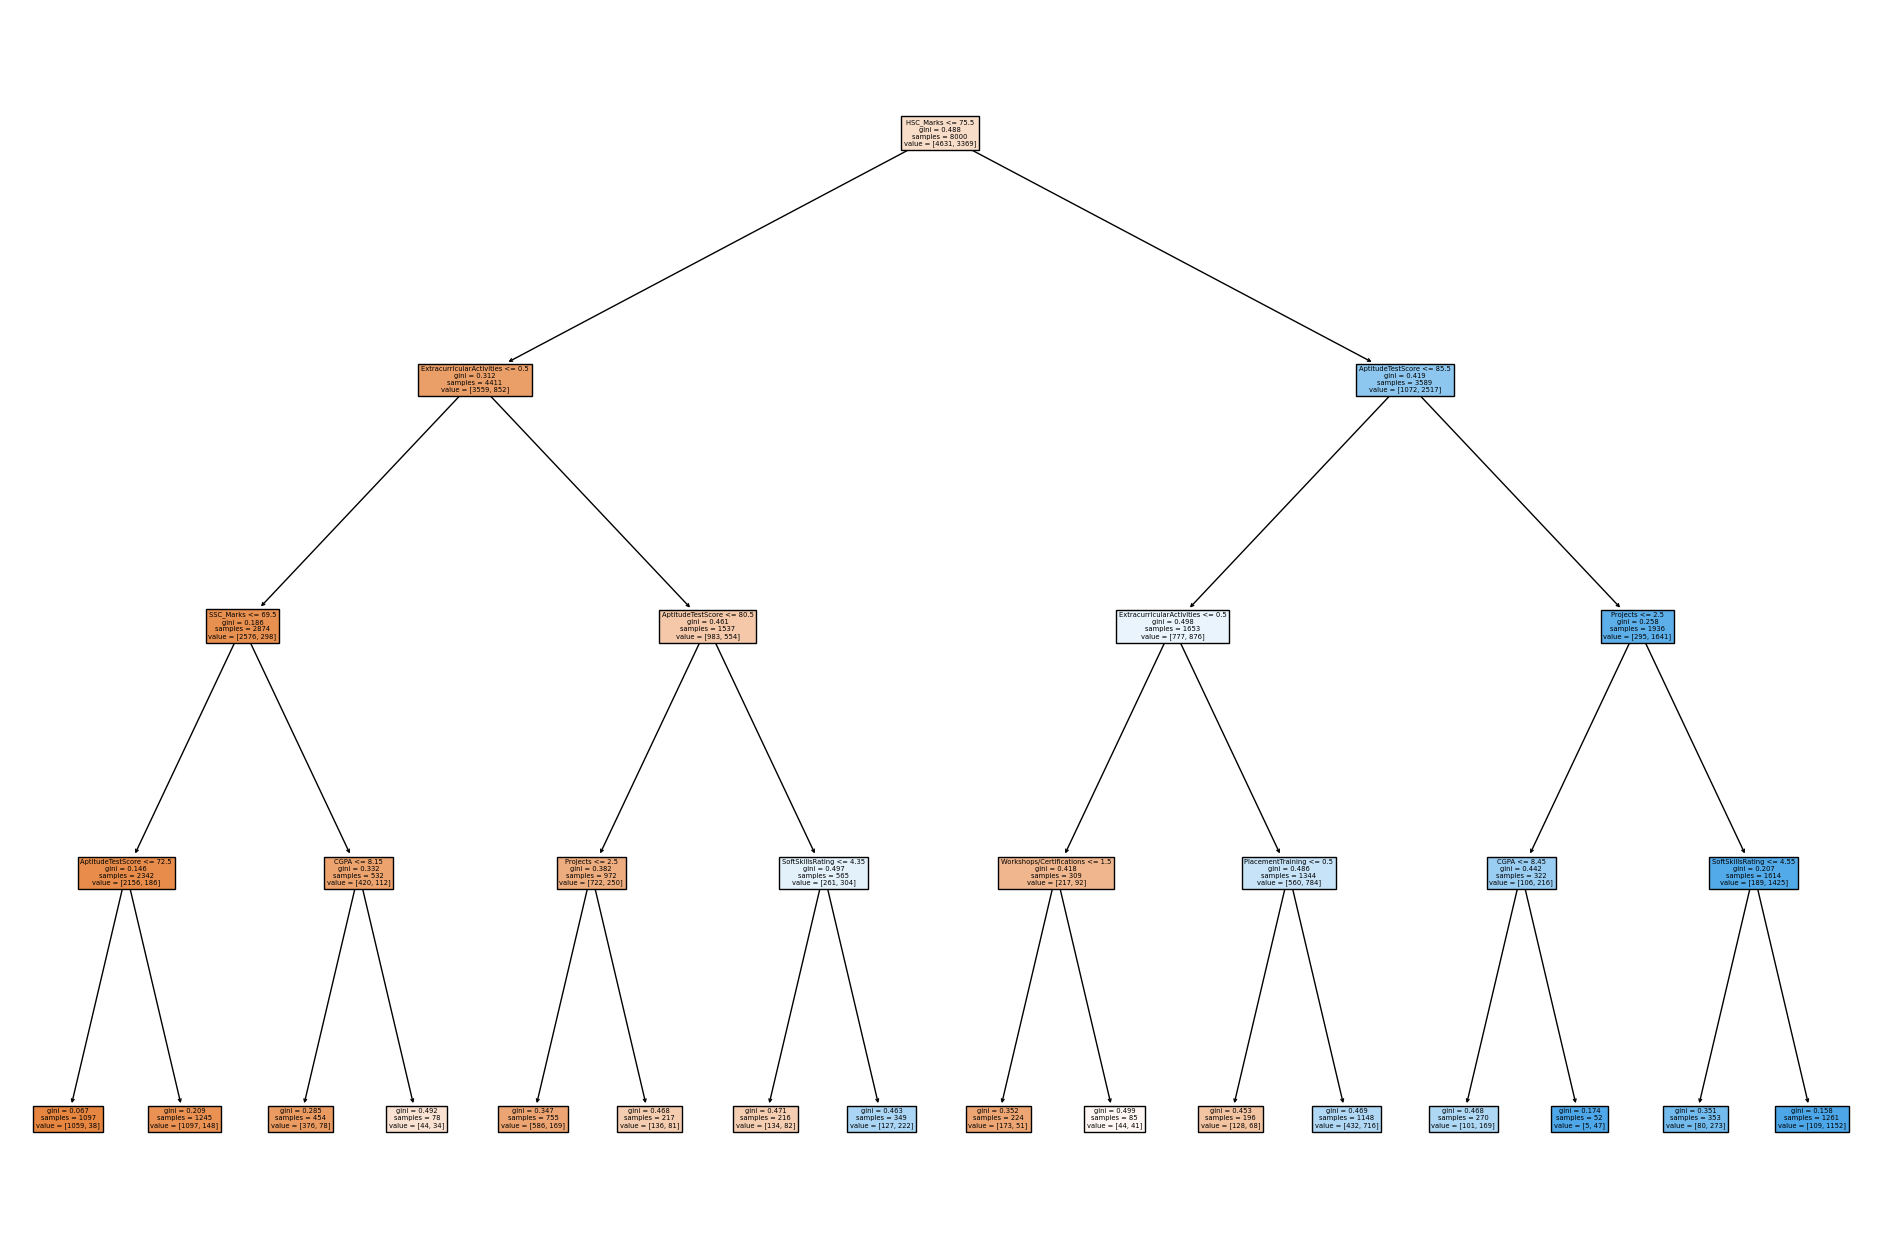

Le pourcentage de bien classés est de : 78.14999999999999 %
Le Recall est de : 0.7560386473429952
La Spécificité est de : 0.7994880546075085
La Precision est de : 0.727061556329849
Le ROC_AUC est de : 0.8461700961237242


,NotPlaced_predit,Placed_predit
NotPlaced_données,937,235
Placed_données,202,626


In [53]:
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(x_train, y_train)
columns = X.columns

# Affichage de l'arbre de décision
plt.figure(figsize=(24,16))
plot_tree(tree, feature_names= X.columns, filled=True)
plt.show()

#Evaluation du modèle
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, tree.predict(x_test))*100} %")
print(f"Le Recall est de : {recall_score(y_test, tree.predict(x_test), pos_label='Placed')}")
print(f"La Spécificité est de : {recall_score(y_test, tree.predict(x_test), pos_label='NotPlaced')}")
print(f"La Precision est de : {precision_score(y_test, tree.predict(x_test), pos_label='Placed')}")
print(f"Le ROC_AUC est de : {roc_auc_score(y_test, tree.predict_proba(x_test)[:, 1])}")
pd.DataFrame(confusion_matrix(y_test, tree.predict(x_test)),
             index = ["NotPlaced_données", "Placed_données"],
             columns = ["NotPlaced_predit", "Placed_predit"])


On peut discuter sur une utilisation de la spécificité comme mesure car il peut apparaître plus important de capter au maximum les observations négatives pour apporter une aide suffisante aux étudiants qui risquent de ne pas s'insérer professionnellement, quitte à catégoriser des étudiants sans difficultés en NotPLaced. Le recall peut aussi défendre son importance car prédire NotPlaced à tort pour un étudiant qui est au bout de ses efforts peut lui procurer du stress et une surchage pouvant aller au burn-out. 
On peut donc utiliser une métrique qui combine ces deux dernières, comme le roc_auc_score. 


La meilleure exactitiude obtenue est 78,15% avec une profondeur maximale à 4, mais on obtient le meilleur roc_auc_score (0,85) pour une profondeur de 5, avec une exactitude à 77,9%. 

On obtient déjà un modèle plutôt intéressant avec un score élévé. L'arbre est difficilement lisible au-delà d'un profondeur de 3 mais on peut évaluer le poids de chaque variable, afin de comprendre quelles sont les plus importantes pour l'insertion professionnelle selon notre modèle. 

In [54]:
pd.DataFrame(tree.feature_importances_,
              index = X.columns, 
              columns = ["Poids le la variable"]).sort_values(
     "Poids le la variable", 
     ascending = False)

,Poids le la variable
HSC_Marks,0.653336
AptitudeTestScore,0.156379
ExtracurricularActivities,0.110608
Projects,0.020251
SoftSkillsRating,0.018151
PlacementTraining,0.016395
CGPA,0.010242
SSC_Marks,0.009528
Workshops/Certifications,0.005110
Internships,0.000000


On remarque que la variable HSC_marks (Higher secondary Marks), analogue aux notes obtenues en première et terminale dans le système français, joue un rôle capital avec un poids au moins 4 fois plus élévé que n'importe quelle autre variable. Vient ensuite le test d'aptitude effectué lors du processus de recrutement et le nombre d'activités extrascolaires effectuées. 

Avec cette remarque, on peut prendre poser des bases solides en sensibilisant et en accompagnant mieux dès le lycée pour permettre une meilleure insertion, en se rattrapant sur un soutien prononcé au test d'aptitude et un encouragement aux activités extrascolaires pour venir en aide aux étudiants 'NotPlaced' par le modèle. 

#### Random Forest

In [66]:
model_rf = RandomForestClassifier(max_depth=5)
model_rf.fit(x_train, y_train)

#Evaluation du modèle
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, model_rf.predict(x_test))*100} %")
print(f"Le Recall est de : {recall_score(y_test, model_rf.predict(x_test), pos_label='Placed')}")
print(f"La Spécificité est de : {recall_score(y_test, model_rf.predict(x_test), pos_label='NotPlaced')}")
print(f"La Precision est de : {precision_score(y_test, model_rf.predict(x_test), pos_label='Placed')}")
print(f"Le ROC_AUC est de : {roc_auc_score(y_test, model_rf.predict_proba(x_test)[:, 1])}")
pd.DataFrame(confusion_matrix(y_test, model_rf.predict(x_test)),
             index = ["NotPlaced_données", "Placed_données"],
             columns = ["NotPlaced_predit", "Placed_predit"])


Le pourcentage de bien classés est de : 79.05 %
Le Recall est de : 0.7415458937198067
La Spécificité est de : 0.8250853242320819
La Precision est de : 0.7496947496947497
Le ROC_AUC est de : 0.8723027031705989


,NotPlaced_predit,Placed_predit
NotPlaced_données,967,205
Placed_données,214,614


On obtient notre meilleur roc_auc_score avec une profondeur maximale de 5. On gardera ce modèle même si, comme pour l'arbre, une profondeur de 4 nous donne entre 0.1 et 0.3% en plus sur l'accuracy, qui est déjà au delà de 79%, plus que ce qu'on a pu avoir avec l'arbre. Notre modèle est donc meilleur que le premier. 

On peut également regarder quelles sont les variables les plus importantes, et comparer avec la première analyse. 

In [71]:
pd.DataFrame(model_rf.feature_importances_,
              index = X.columns, 
              columns = ["Poids le la variable"]).sort_values(
     "Poids le la variable", 
     ascending = False)

,Poids le la variable
HSC_Marks,0.299859
AptitudeTestScore,0.193655
ExtracurricularActivities,0.139315
Projects,0.136419
Workshops/Certifications,0.068804
SoftSkillsRating,0.049744
CGPA,0.045580
SSC_Marks,0.043754
PlacementTraining,0.021179
Internships,0.001692


On obtient le même ordre pour les 4 variables les plus importantes, avec un écart plus réduit entre les variables, et donc on a quatre moyens avec une efficacité très proche pour agir sur le placement des étudiants (bien que HSC_marks ait quand même un avantage certain). La variable Workshops/Certifiations gagne en importance, se plaçant à la 5ème position. 

#### Neural Network

La partie en commentaire est une boucle parallélisée pour obtenir la meilleure combinaison de couche parmi 500 combinaisons de combres premiers (choix arbitraire par constat, après plusieurs tests les nombres premiers apportaient plus souvent satisfaction)

In [74]:

"""
premiers = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
n_jobs = -1  # Utiliser tous les cœurs disponibles

# Fonction d'entraînement d'un modèle
def entrainer_mlp(_):
    combinaison = random.sample(premiers, 9)
    test_mlp = MLPClassifier(hidden_layer_sizes=combinaison, max_iter=1000, random_state=42, activation='relu')
    test_mlp.fit(x_train, y_train)
    rocauc = roc_auc_score(y_test, test_mlp.predict_proba(x_test)[:, 1])
    return (rocauc, test_mlp, combinaison)

# Exécution parallèle
resultats = joblib.Parallel(n_jobs=n_jobs)(joblib.delayed(entrainer_mlp)(i) for i in range(500))

# Sélection du meilleur modèle
rocauc, model_mlp, couche = max(resultats, key=lambda x: x[0])
"""


model_mlp = MLPClassifier(hidden_layer_sizes=[61, 89, 13, 3, 71, 19, 73, 59, 53], max_iter=1000, random_state=42, activation='relu')
model_mlp.fit(x_train, y_train)

# Évaluation du meilleur modèle
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, model_mlp.predict(x_test)) * 100:.2f} %")
print(f"Le Recall est de : {recall_score(y_test, model_mlp.predict(x_test), pos_label='Placed')}")
print(f"La Spécificité est de : {recall_score(y_test, model_mlp.predict(x_test), pos_label='NotPlaced')}")
print(f"La Precision est de : {precision_score(y_test, model_mlp.predict(x_test), pos_label='Placed')}")
print(f"Le ROC_AUC est de : {roc_auc_score(y_test, model_mlp.predict_proba(x_test)[:, 1])}")

# Matrice de confusion
df_cm = pd.DataFrame(confusion_matrix(y_test, model_mlp.predict(x_test)),
                     index=["NotPlaced_données", "Placed_données"],
                     columns=["NotPlaced_predit", "Placed_predit"])
print(df_cm)


Le pourcentage de bien classés est de : 80.40 %
Le Recall est de : 0.7101449275362319
La Spécificité est de : 0.8703071672354948
La Precision est de : 0.7945945945945946
Le ROC_AUC est de : 0.8781450429506521
                   NotPlaced_predit  Placed_predit
NotPlaced_données              1020            152
Placed_données                  240            588


Le meilleur roc_auc score obtenu est de 0.88 %. Par curiosité j'ai fait tourner le code pour obtenir la meilleure exactitude possible, étant convaincu de pouvoir atteindre la barre symbolique des 80%. Cette barre a été atteinte, avec roc_auc score très légèrement en dessous du meilleur score obtenu (au millième).

On a alors encore amélioré nos résultats avec ce modèle, autant sur le roc_auc score que sur l'exactitude. Comparons maintenant l'importance des variables définies par le réseau de neurones. 


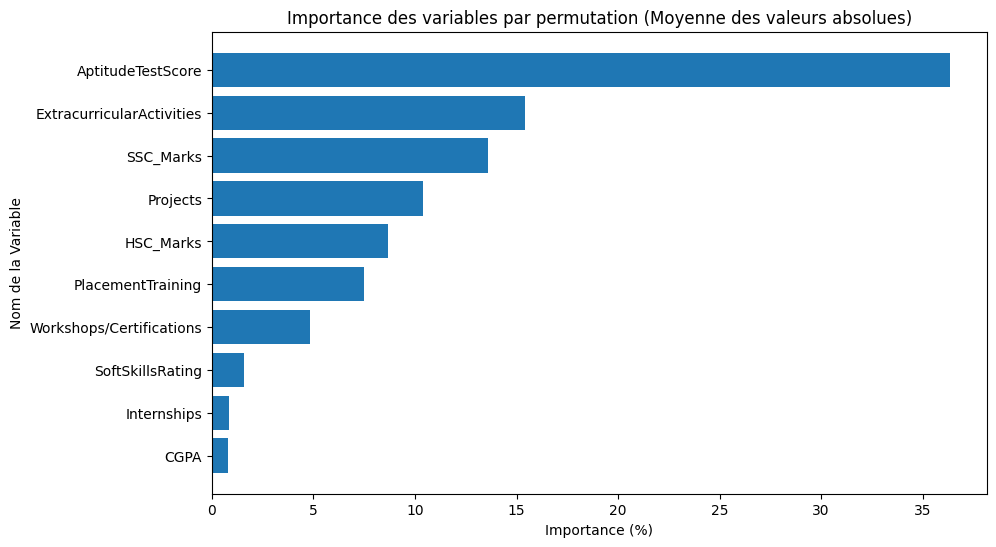

In [95]:
# Évaluation de l'importance des features par permutation
perm_importance = permutation_importance(model_mlp, x_test, y_test, scoring="accuracy")

# Moyenne des valeurs absolues des importances pour chaque feature à travers toutes les répétitions
sum_abs_mean_importances = np.mean(np.abs(perm_importance.importances), axis=1)

# Calcul du pourcentage d'importance
importance_percentage = sum_abs_mean_importances / np.sum(sum_abs_mean_importances) * 100

# Tri des features par importance
sorted_idx = np.argsort(importance_percentage)

# Remplacer les indices par les noms des features
sorted_feature_names = [X.columns[i] for i in sorted_idx]

# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, importance_percentage[sorted_idx])
plt.xlabel("Importance (%)")
plt.ylabel("Nom de la Variable")
plt.title("Importance des variables par permutation (Moyenne des valeurs absolues)")
plt.show()


Après des recherches, j'ai trouvé cette méthode d'évaluation d'importance par permutation. Il était proposé de prendre la moyennes des importances, mais une importance négative pouvait être compensée par une importance positive, alors j'ai préféré faire une moyenne des valeurs absolues pour être certain de capter toute l'influence des variables. 

La variable HSC_Marks, qui dominait le classement pour l'abre et la forêt se retrouve seulement 5ème avec le réseau de neurones. Le test d'aptitude, qui était deuxième, passe largement en tête. Dans les 4 premières variables influentes, trois variables sont présentes peu importe le modèle utilisé : AptitudeTestScore, ExtraCurricularActivities et Projects. Ce sont donc nos pistes privilégiées pour venir en aide aux étudiants 'NotPlaced' afin d'augmenter leurs chances d'être facilement insérés. 

On a, selon les modèles, deux autres variables qui ne sont pas très différentes l'une de l'autre car elles se réfèrent toutes les deux aux notes obtenus au lycée. (HSC_Marks est l'équivalent du contrôle continu en première et terminale et SSC_Marks est l'équivalent du Baccalauréat). Ce rappprochement permet de mettre en place un travail dès le lycée influant sur les deux variables en même temps, afin de maximiser les chances des étudiants d'être insérés facilement.  